In [1]:
import pandas as pd
import numpy as np
import sys
import os
import matplotlib.pyplot as plt
import graphviz
import itertools
#from sklearn.inspection import DecisionBoundaryDisplay
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.model_selection import train_test_split
from sklearn.impute import KNNImputer
# import Kmeans from sklearn
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn import tree
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, mean_absolute_error
from typing import List, Union, Any, Tuple, Dict
import time
from permetrics.regression import RegressionMetric
import oapackage
from scipy.stats import wasserstein_distance, binned_statistic

import warnings
warnings.filterwarnings('ignore')

# Project path
ppath = sys.path[0] + '/../'
sys.path.append(os.path.join(ppath, 'code'))
from discretizers import *
from use_cases import *

/Users/eylai/anaconda3/envs/lucid/lib/python3.9/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/Users/eylai/anaconda3/envs/lucid/lib/python3.9/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.4' currently installed).
  from pandas.core import (


(CVXPY) Sep 24 06:03:34 PM: Encountered unexpected exception importing solver GLOP:
RuntimeError('Unrecognized new version of ortools (9.10.4067). Expected < 9.10.0. Please open a feature request on cvxpy to enable support for this version.')
(CVXPY) Sep 24 06:03:34 PM: Encountered unexpected exception importing solver PDLP:
RuntimeError('Unrecognized new version of ortools (9.10.4067). Expected < 9.10.0. Please open a feature request on cvxpy to enable support for this version.')


In [3]:
raw_data = pd.read_csv(os.path.join(ppath, 'data', 'uciml_pima-indians-diabetes-database', 'diabetes.csv'))
dataset = 'pima'
min_num_bins = 2
max_num_bins = 20
target = 'Outcome'
semantic_metrics = ['gpt_distance', 'l2_norm', 'KLDiv']
attributes = {'Age': [-1, 18, 35, 50, 65, 100], 'Glucose': [-1, 140, 200], 'BMI': [-1, 18.5, 25, 30, 68], }

for attr, gold_standard_bins in attributes.items():
    
    ss = get_data_imputation_search_space(raw_data, attr, target, gold_standard_bins, min_num_bins, max_num_bins)
    
    break

gold-standard [-1, 18, 35, 50, 65, 100]
equal-width [20.0, 51.0, 81.0]
equal-frequency [20.0, 29.0, 81.0]
chi-merge [20.0, 30.0, 82.0]
kbins [20.0, 51.0, 81.0]
kbins-quantile [20.0, 29.0, 81.0]
decision-tree [20.0, 28.5, 82.0]
kmeans [20.0, 26.55466666666669, 82.0]
random-forest [20.0, 24.5, 29.5, 82.0]
equal-width [20.0, 41.0, 61.0, 81.0]
equal-frequency [20.0, 25.0, 36.0, 81.0]
chi-merge [20.0, 24.0, 30.0, 82.0]
kbins [20.0, 41.0, 61.0, 81.0]
kbins-quantile [20.0, 25.0, 36.0, 81.0]
decision-tree [20.0, 28.5, 62.5, 82.0]
kmeans [20.0, 25.152173913043505, 39.9025974025974, 82.0]
random-forest [20.0, 21.5, 35.50000000000001, 55.833333333333336, 82.0]
equal-width [20.0, 36.0, 51.0, 66.0, 81.0]
equal-frequency [20.0, 24.0, 29.0, 40.75, 81.0]
chi-merge [20.0, 24.0, 30.0, 42.0, 82.0]
kbins [20.0, 36.0, 51.0, 66.0, 81.0]
kbins-quantile [20.0, 24.0, 29.0, 40.75, 81.0]
decision-tree [20.0, 28.5, 42.5, 62.5, 82.0]
kmeans [20.0, 23.911538461538484, 33.330827067669176, 45.083333333333336, 82.0]
r

In [12]:
def cluster_sampling(search_space, num_samples:int=2, frac_outlier_samples=0.5, semantic_metric='l2_norm') -> List:

    pca = PCA(n_components=2)
    X = np.array([p.binned_values for p in search_space.candidates])
    processed = pca.fit_transform(X)
    pcadf = pd.DataFrame( data = processed, columns = ['PC1', 'PC2'])

    clusterer = hdbscan.HDBSCAN(min_cluster_size=2)
    pca = PCA(n_components=5)
    X = np.array([p.binned_values for p in search_space.candidates])
    #print("X:", X)
    X = pca.fit_transform(X)
    hdbscan_clusters = clusterer.fit_predict(X)
    print("Number of clusters:", len(np.unique(hdbscan_clusters)))

    outliers = [0 if c == -1 else 1 for c in hdbscan_clusters]

    plt.scatter(pcadf['PC1'], pcadf['PC2'], c=outliers, cmap='coolwarm', alpha=0.5)
    plt.xlabel('PC1')
    plt.ylabel('PC2')
    plt.show()

    # Get indices of -1 cluster
    outlier_indices = np.where(hdbscan_clusters == -1)[0]
    outliers = [search_space.candidates[i] for i in outlier_indices]
    if semantic_metric == 'l2_norm':
        semantics = [p.l2_norm for p in outliers]
    elif semantic_metric == 'gpt_distance':
        semantics = [p.gpt_distance for p in outliers]
    elif semantic_metric == 'KLDiv':
        semantics = [p.KLDiv for p in outliers]
    else: raise ValueError("Invalid semantic metric")
    utility = [p.utility for p in outliers]
    outlier_points = [np.array(semantics), np.array(utility)]
    outlier_indices = np.random.choice(outlier_indices, int(len(outlier_indices) * frac_outlier_samples), replace=False)

    sampled_indices = []
    for c in np.unique(hdbscan_clusters):
        if c == -1: sampled_indices.extend(outlier_indices)
        cluster_indices = np.where(hdbscan_clusters == c)[0]
        # Sample two partition from the cluster
        sampled_indices.extend(np.random.choice(cluster_indices, num_samples, replace=False))
    
    # Add gold standard partition to the sampled partitions
    if 0 not in sampled_indices:
        sampled_indices.append(0)
    sampled_partitions = [search_space.candidates[i] for i in sampled_indices]
    explored_points, pareto_points = get_pareto_front(sampled_partitions, semantic_metric)
    
    return explored_points, pareto_points, outlier_points


Datapoint shape to compute Pareto points: (2, 146)
Pareto points: [[0.5705384594247325, 0.9388020833333334], [0.5705384594247325, 0.9388020833333334], [0.815344366987309, 0.7734375], [0.9241715724628347, 0.76953125], [0.943075473550203, 0.765625], [0.9572108110089547, 0.7565104166666666], [1.0, 0.7330729166666666]]
Number of clusters: 14


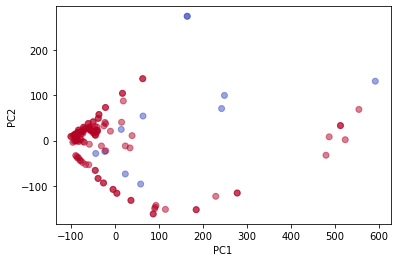

Datapoint shape to compute Pareto points: (2, 19)
Pareto points: [[0.5705384594247325, 0.9388020833333334], [0.6944659540122743, 0.64453125], [0.6804284030273491, 0.72265625]]


In [13]:
#for semantic_metric in semantic_metrics:
semantic_metric = 'l2_norm'
datapoints, gt_pareto_points = get_pareto_front(ss.candidates, semantic_metric)
explored_points, est_pareto_points, outliers = cluster_sampling(ss, 1, 0.5, semantic_metric)

Percentage of outliers: 7.534246575342466


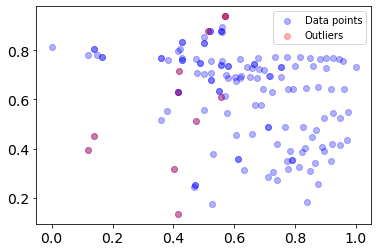

In [14]:
datapoints = np.array(datapoints)
outliers = np.array(outliers)
print("Percentage of outliers:", len(outliers[0]) / len(datapoints[0]) * 100)
# Set size of the plot
f, ax = plt.subplots(figsize=(6, 4))
ax.scatter(datapoints[0], datapoints[1], c='blue', label='Data points', alpha=0.3)
ax.scatter(outliers[0], outliers[1], c='red', label='Outliers', alpha=0.3)
ax.xaxis.set_tick_params(labelsize=14)
ax.yaxis.set_tick_params(labelsize=14)
ax.legend()
plt.show()